In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold # Para validar

from utilidades.graficar import ver_dispersion

# Carga del train

In [2]:
train = pd.read_csv('data/train_limpio.csv')

X = train.drop(columns=['precio'])
y = train['precio']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('X_train.shape\t', X_train.shape, '\ty_train.shape\t', y_train.shape)
print('X_test.shape\t', X_test.shape, '\tX_test.shape\t', y_test.shape)

X_train.shape	 (180000, 70) 	y_train.shape	 (180000,)
X_test.shape	 (60000, 70) 	X_test.shape	 (60000,)


# Random Forest Regressor

In [3]:
# n_estimators
num_estimadores = 200
# n_jobs
workers = 1
rfr = RandomForestRegressor(n_estimators=num_estimadores, n_jobs=workers)

# Evaluación del predictor

In [4]:
kf = KFold(n_splits=10)
# Listas para guardar los puntajes y errores de la evaluación
scores = []
errors = []

In [5]:
%%time
for train_index, test_index in kf.split(train) :
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    rfr.fit(X_train, y_train)
    prediction_t = rfr.predict(X_test)
    
    scores.append(rfr.score(X_test, y_test))
    errors.append(mean_absolute_error(y_test, prediction_t))

CPU times: user 1h 3min 18s, sys: 8.92 s, total: 1h 3min 27s
Wall time: 1h 3min 27s


In [6]:
puntajes = np.array(scores)
errores = np.array(errors)

print(errores.mean().round(0))
print(puntajes.mean().round(3))

668952.0
0.726


In [7]:
%%time
rfr = RandomForestRegressor(n_estimators=num_estimadores, n_jobs=workers, random_state=42)
rfr.fit(X_train, y_train)

CPU times: user 6min 11s, sys: 352 ms, total: 6min 11s
Wall time: 6min 11s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

### Predicción del y_test

In [8]:
prediction_t = rfr.predict(X_test)
mean_absolute_error(y_test, prediction_t)

670472.3745259217

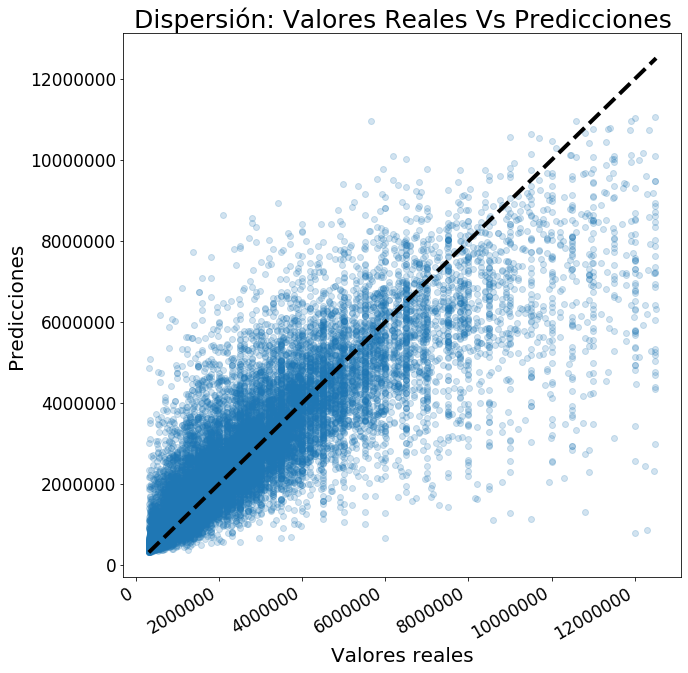

In [9]:
ver_dispersion(y_test, prediction_t)

# Validación  (variable para modelo a entrenar = rfr)

In [13]:
'''
%%time
transf = True
kfold = KFold(5, True, 42)
for i, (train_index, test_index) in enumerate(kfold.split(X)):
    # Se parte el dataset en dos, train y test, con el train entreno
    # y con el test evaluo como predice mi algoritmo
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    if transf:
        y_train = np.log(y_train)
    # Me creo una instancia del modelo y luego lo entreno con los datos(con fit(X,y))
    rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    rfr.fit(X_train, y_train)
    predicciones_t = rfr.predict(X_test)
    if transf:
        predicciones_t = np.exp(predicciones_t)

    # Me fijo como me da el resultado
    print(f"Error de fold N°{i} es : {round(mean_absolute_error(y_test, predicciones_t), 2)}")
'''

'\n%%time\ntransf = True\nkfold = KFold(5, True, 42)\nfor i, (train_index, test_index) in enumerate(kfold.split(X)):\n    # Se parte el dataset en dos, train y test, con el train entreno\n    # y con el test evaluo como predice mi algoritmo\n    X_train, X_test = X.iloc[train_index], X.iloc[test_index]\n    y_train, y_test = y.iloc[train_index], y.iloc[test_index]\n    if transf:\n        y_train = np.log(y_train)\n    # Me creo una instancia del modelo y luego lo entreno con los datos(con fit(X,y))\n    rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1)\n    rfr.fit(X_train, y_train)\n    predicciones_t = rfr.predict(X_test)\n    if transf:\n        predicciones_t = np.exp(predicciones_t)\n\n    # Me fijo como me da el resultado\n    print(f"Error de fold N°{i} es : {round(mean_absolute_error(y_test, predicciones_t), 2)}")\n'

# Predicción del test (para submit)

In [11]:
'''
test = pd.read_csv('data/test_limpio.csv')
y_pred = rfr.predict(test)
'''

"\ntest = pd.read_csv('data/test_limpio.csv')\ny_pred = rfr.predict(test)\n"

# Generación de submit

In [12]:
'''
ids = pd.read_csv('data/test.csv', usecols=['id'])

submit = pd.DataFrame(y_pred, columns=['target'])
submit.insert(0, 'id', ids)
submit.to_csv(f"submits/submit_Rand_Forest.csv", index=False)
'''

'\nids = pd.read_csv(\'data/test.csv\', usecols=[\'id\'])\n\nsubmit = pd.DataFrame(y_pred, columns=[\'target\'])\nsubmit.insert(0, \'id\', ids)\nsubmit.to_csv(f"submits/submit_Rand_Forest.csv", index=False)\n'